## Packages import

In [42]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import outlines
import time
import torch
import re
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import subprocess
from sklearn.metrics import f1_score
import numpy as np
import json
import unicodedata
import pickle as pkl
from typing import Literal, List
from tqdm import tqdm
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

## Cleaning data

In [2]:
def xstr(obj):
    return obj or ""
    
def clean_obj(obj):
    # remove unicode issues
    x = json.dumps(obj)
    x = re.sub(r"\\\\(?=u[0-9a-f]{4})", r"\\", x)
    x = json.loads(x)
    return x

def clean_text(text, max_linejumps = 1):
    # remove "\t" and "\r"
    cleaned_text = re.sub("\t", "", text)
    cleaned_text = re.sub("\r", "", cleaned_text)
    
    # remove duplicated spaces
    cleaned_text = re.sub(" +", " ", cleaned_text)

    # remove spaces around linejumps
    cleaned_text = re.sub(" +(?=\n)|(?<=\n) +", "", cleaned_text)

    # remove starting or ending linejumps and spaces
    cleaned_text = re.sub("^\n+|\n+$", "", cleaned_text)

    # remove duplicated linejumps
    cleaned_text = re.sub(
        "\n{" + str(max_linejumps) + ",}", "\n" * max_linejumps, cleaned_text
    )
    return cleaned_text

def normalize(item):
    return unicodedata.normalize("NFKD", item)

def transform_job(obj):
    obj = clean_obj(obj)
    n_sections = 6
        
    # Format
    job = {
        'title': xstr(obj.get('name', '')),
        'summary': xstr(obj.get('summary', '')),
        'sections': [
            {
                'title': section.get('title'),
                'description': section.get('description')
            }
            for section in obj.get('sections') or [] 
            if section.get('title') or section.get('description')
        ]
    }
    for title in ["requirements", "responsibilities", "culture", "benefits", "interviews"]:
        value = obj.get(title)
        if value is not None:
            job["sections"].append({"title": title.upper(), "description": value})

    # Structure
    title = job["title"]
    summary = job["summary"]
    sections = []
    for sec in job["sections"][:n_sections]:
        sec_text = ""
        # title
        if sec["title"]:
            sec_text += f"TITLE: {sec['title']}\n"
        # description
        if sec["description"]:
            sec_text += f"DESCRIPTION: {sec['description']}\n"
        sections.append(sec_text)
        
    # Merge
    output_body = ""
    if clean_text(title):
        output_body += f"TITLE\n{clean_text(title)}\n\n"
    if clean_text(summary):
        output_body += f"SUMMARY\n{clean_text(summary)}\n\n"

    for index, sec in enumerate(sections):
        if sec:
            output_body += f"SECTION {index}\n{clean_text(sec)}\n\n"
        
    output_body = normalize(output_body).strip()
    return output_body

## Reading jobs

In [ ]:
# 1. Load the data
with open('/home/ibrahim/Downloads/tagging_dataset/job_key_to_json.pkl', 'rb') as f:
    raw_jobs = pkl.load(f)

cleaned_jobs_dict = {}

for job_id, job_obj in raw_jobs.items():
    try:
        # Apply cleaning pipeline
        cleaned_text = transform_job(job_obj)
        
        # Store in our new variable
        cleaned_jobs_dict[job_id] = cleaned_text
    except Exception as e:
        print(f"Error processing job {job_id}: {e}")

print(f"Total jobs in variable: {len(cleaned_jobs_dict)}")

Error processing job 7faf6c1c0930f16fa6c26c0867f62e7c54364488: 'str' object has no attribute 'get'
Error processing job 9451464: 'str' object has no attribute 'get'
Error processing job 9491271: 'str' object has no attribute 'get'
Error processing job 9498512: 'str' object has no attribute 'get'
Error processing job 9502189: 'str' object has no attribute 'get'
Error processing job 9492740: 'str' object has no attribute 'get'
Error processing job 9500002: 'str' object has no attribute 'get'
Error processing job 9509026: 'str' object has no attribute 'get'
Error processing job 9507060: 'str' object has no attribute 'get'
Error processing job 9466452: 'str' object has no attribute 'get'
Error processing job 9504173: 'str' object has no attribute 'get'
Error processing job 878446: 'str' object has no attribute 'get'
Error processing job 9517837: 'str' object has no attribute 'get'
Error processing job 9513274: 'str' object has no attribute 'get'
Error processing job 9520338: 'str' object h

## Reading Tags

In [ ]:
base_path = "/home/ibrahim/Downloads/tagging_dataset/open_ai_generations"

tags_dict = {}

for key in cleaned_jobs_dict.keys():
    filename = f"{key}.json"
    file_path = os.path.join(base_path, filename)
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            file_content = json.load(f)
            
            tags_dict[key] = file_content
            
    except FileNotFoundError:
        print(f"Error processing file: {filename} (File not found)")
    except json.JSONDecodeError:
        print(f"Error processing file: {filename} (Invalid JSON format)")
    except Exception as e:
        print(f"Error processing file: {filename} (Unexpected error: {e})")

# Verification
print(f"\nSuccessfully loaded {len(tags_dict)} tags files.")

Error processing file: dbf91d503165ecf3a55dfb8e660441ce6073fc58.json (File not found)
Error processing file: 6b52fad0b4069ec4ce3f6a73701a9bbfd44ac363.json (File not found)
Error processing file: d0e78427b8c56566c3335ec45f1c024c3d2f28ce.json (File not found)
Error processing file: b87be3c53bbcdc8f64e54e00ce4b037dfeb3a1c8.json (File not found)
Error processing file: 3f3926a1c37b3e752121099eec386e6ed92f5def.json (File not found)
Error processing file: 22085034061f8f536f5af7fa684cc9c55095ac26.json (File not found)
Error processing file: a3fd37ab8284ce157243c17bae72df38e54c93c7.json (File not found)
Error processing file: 6db4ba3805f7e32bb01e2b9a390bec28a02492e1.json (File not found)
Error processing file: 9ab23643d2e37d2c604c148a9e275d09544172ab.json (File not found)
Error processing file: 27eb257bae4f308b6e93fd30e3b4e5c1fca5239e.json (File not found)
Error processing file: 02600436dccbbe6e01e01f9be51a168f4dada9ef.json (File not found)
Error processing file: c49e1317563c5325b75f5aa3c1bf88e

## Create the four tags datasets

In [ ]:
education_gold_dict = {}
experience_gold_dict = {}
contract_gold_dict = {}
language_gold_dict = {}

for file_key, content in tags_dict.items():
    education_gold_dict[file_key] = content.get('Education')
    experience_gold_dict[file_key] = content.get('Experience')
    contract_gold_dict[file_key] = content.get('Contract')
    language_gold_dict[file_key] = content.get('Language')

print(f"Split {len(tags_dict)} entries into 4 specialized dictionaries.")

Split 29628 entries into 4 specialized dictionaries.


## Cleaning the labels

In [ ]:
to_replace = ['other', 'Franchise', 'Contract']

for key, value in contract_gold_dict.items():
    if value in to_replace:
        contract_gold_dict[key] = 'Other'

unique_values = set(contract_gold_dict.values())
print(f"Unique values remaining: {unique_values}")

Unique values remaining: {'Freelance', 'Permanent', 'Temporary', 'Internship', 'Other', 'Apprenticeship'}


In [ ]:
experience_mapping = {
    'other': 'Other',
    'Associate': 'Associate (1–3 years)'
}

for key, value in experience_gold_dict.items():
    if value in experience_mapping:
        experience_gold_dict[key] = experience_mapping[value]

updated_values = set(experience_gold_dict.values())
print(f"Updated categories: {updated_values}")

Updated categories: {'Experienced (3–7 years)', 'Executive (12+ years)', 'Entry-Level (0–1 years)', 'Lead (7–12 years)', 'Associate (1–3 years)', 'Other'}


In [ ]:
print(set(language_gold_dict.values()))l
print(set(experience_gold_dict.values()))
print(set(education_gold_dict.values()))
print(set(contract_gold_dict.values()))

{'it', 'zh', 'pt', 'nl', 'ja', 'ar', 'pl', 'es', 'fr', 'en', 'de', 'tr'}
{'Experienced (3–7 years)', 'Executive (12+ years)', 'Entry-Level (0–1 years)', 'Lead (7–12 years)', 'Associate (1–3 years)', 'Other'}
{"Bachelor's Degree", 'Without Diploma', 'PhD/Doctorate', "Master's Degree", "Associate's Degree", 'High School Diploma', 'Other'}
{'Freelance', 'Permanent', 'Temporary', 'Internship', 'Other', 'Apprenticeship'}


## Data for the current experience

In [ ]:
n = 3000
keys_slice = list(islice(language_gold_dict, n))

# Create the subsets
Language_truth = {k: language_gold_dict[k] for k in keys_slice}
Experience_truth = {k: experience_gold_dict[k] for k in keys_slice}
Education_truth = {k: education_gold_dict[k] for k in keys_slice}
Contract_truth = {k: contract_gold_dict[k] for k in keys_slice}
jobs = {k: cleaned_jobs_dict[k] for k in keys_slice}

## Loading the model

In [ ]:
model_name = "Qwen/Qwen3-0.6B"

print("Loading model:", model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16 
)

model_1 = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config 
)

model = outlines.from_transformers(model_1, tokenizer)

Loading model: Qwen/Qwen3-0.6B


## Prediction of the education level

In [13]:
labels_educ = list(set(Education_truth.values()))

print("Number of labels:", len(labels_educ))
print(labels_educ)

Number of labels: 7
["Bachelor's Degree", 'Without Diploma', 'PhD/Doctorate', "Master's Degree", "Associate's Degree", 'High School Diploma', 'Other']


In [14]:
generator_educ_tag = outlines.Generator(model, eval('Literal'+str(labels_educ)))

In [ ]:
tags_education = {}

for job_id, job_text in tqdm(jobs.items(), desc="Tagging Education"):
    try:
        prompt = f"""Task: Identify the required education level for the job description below.

Job Description:
{job_text}
"""
        result = generator_educ_tag(prompt)
        
        tags_education[job_id] = result

    except Exception as e:
        print(f"\nError on job {job_id}: {e}")
        tags_education[job_id] = "Other"

# 4. Final check
print(f"Finished! Tagged {len(tags_education)} jobs.")

Tagging Education:   0%|          | 0/3000 [00:00<?, ?it/s]W1219 12:26:35.482000 11815 site-packages/torch/_dynamo/convert_frame.py:1125] WON'T CONVERT _apply_token_bitmask_inplace_kernel /home/ibrahim/miniconda3/envs/llm/lib/python3.12/site-packages/outlines_core/kernels/torch.py line 43 
W1219 12:26:35.482000 11815 site-packages/torch/_dynamo/convert_frame.py:1125] due to: 
W1219 12:26:35.482000 11815 site-packages/torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1219 12:26:35.482000 11815 site-packages/torch/_dynamo/convert_frame.py:1125]   File "/home/ibrahim/miniconda3/envs/llm/lib/python3.12/site-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1219 12:26:35.482000 11815 site-packages/torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1219 12:26:35.482000 11815 site-packages/torch/_dynamo/convert_frame.py:1125]                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
W1219 12:26:35.4820

Finished! Tagged 3000 jobs.


## Model evaluation

In [50]:
keys = Education_truth.keys()

y_true = [Education_truth[k] for k in keys]
y_pred = [tags_education[k] for k in keys]

Accuracy: 0.1373
Weighted Precision: 0.3349
Weighted Recall: 0.1373
Weighted F1 Score: 0.1433

Classification Report:

                     precision    recall  f1-score   support

 Associate's Degree       0.14      0.39      0.21       398
  Bachelor's Degree       0.14      0.09      0.11       471
High School Diploma       0.01      0.07      0.02        59
    Master's Degree       0.13      0.18      0.15       413
              Other       0.55      0.09      0.15      1513
      PhD/Doctorate       0.01      0.23      0.01        13
    Without Diploma       0.00      0.00      0.00       133

           accuracy                           0.14      3000
          macro avg       0.14      0.15      0.09      3000
       weighted avg       0.33      0.14      0.14      3000



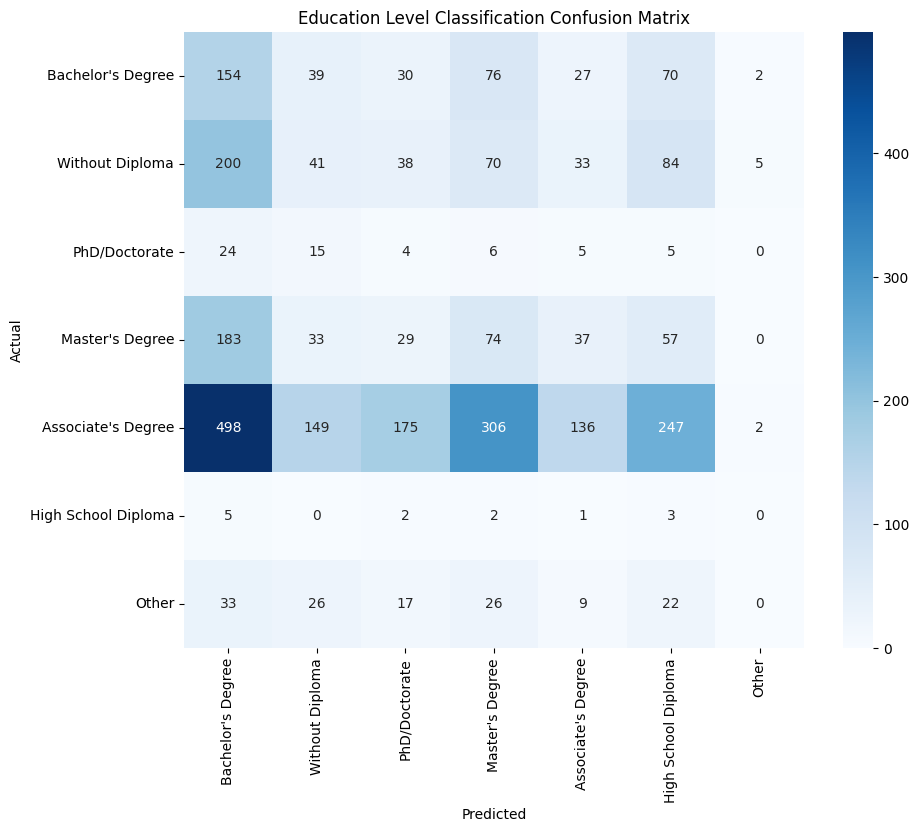

In [52]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# 3. Visualizing the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Education Level Classification Confusion Matrix')
plt.show()

## Using the model for the experience level

In [21]:
labels_exp = list(set(Experience_truth.values()))

print("Number of labels:", len(labels_exp))
print(labels_exp)

Number of labels: 6
['Experienced (3–7 years)', 'Executive (12+ years)', 'Entry-Level (0–1 years)', 'Lead (7–12 years)', 'Associate (1–3 years)', 'Other']


In [22]:
generator_exp_tag = outlines.Generator(model, eval('Literal'+str(labels_exp)))

In [ ]:
tags_experience = {}

for job_id, job_text in tqdm(jobs.items(), desc="Tagging Experience"):
    try:
        prompt = f"""Task: Identify the required experieEducation_truthnce level for the job description below.

Job Description:
{job_text}
"""
        result = generator_exp_tag(prompt)

        tags_experience[job_id] = result

    except Exception as e:
        print(f"\nError on job {job_id}: {e}")
        tags_experience[job_id] = "Other" 

print(f"Finished! Tagged {len(tags_experience)} jobs.")

Tagging Experience: 100%|██████████| 3000/3000 [33:06<00:00,  1.51it/s]

Finished! Tagged 3000 jobs.


In [47]:
keys = Experience_truth.keys()

y_true = [Experience_truth[k] for k in keys]
y_pred = [tags_experience[k] for k in keys]

Accuracy: 0.2323
Weighted Precision: 0.3045
Weighted Recall: 0.2323
Weighted F1 Score: 0.2466

Classification Report:

                         precision    recall  f1-score   support

  Associate (1–3 years)       0.19      0.21      0.20       599
Entry-Level (0–1 years)       0.34      0.11      0.17       986
  Executive (12+ years)       0.00      0.00      0.00         8
Experienced (3–7 years)       0.41      0.38      0.40      1102
      Lead (7–12 years)       0.03      0.29      0.06        91
                  Other       0.06      0.05      0.06       214

               accuracy                           0.23      3000
              macro avg       0.17      0.17      0.15      3000
           weighted avg       0.30      0.23      0.25      3000



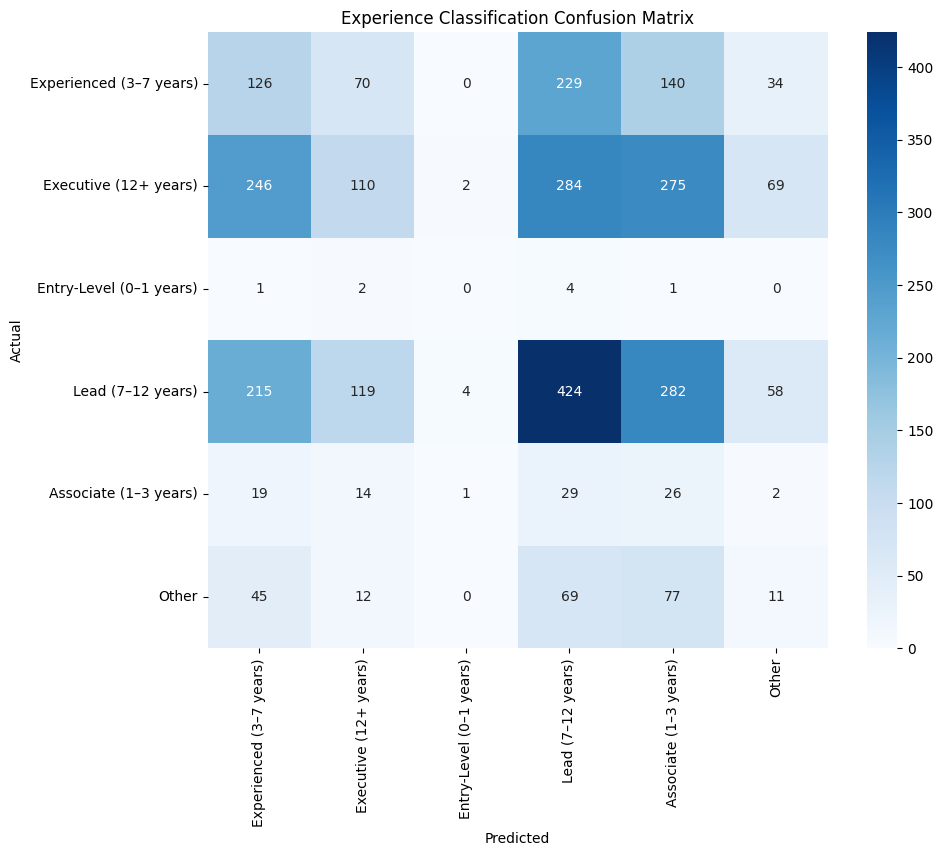

In [49]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# 3. Visualizing the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Experience Classification Confusion Matrix')
plt.show()

## Using the model for the contract

In [28]:
labels_contr = list(set(Contract_truth.values()))

print("Number of labels:", len(labels_contr))
print(labels_contr)

Number of labels: 6
['Freelance', 'Permanent', 'Temporary', 'Internship', 'Other', 'Apprenticeship']


In [29]:
generator_contr_tag = outlines.Generator(model, eval('Literal'+str(labels_contr)))

In [ ]:
tags_contract = {}

for job_id, job_text in tqdm(jobs.items(), desc="Tagging Contract"):
    try:
        prompt = f"""Task: Identify the contract type for the job description below.

Job Description:
{job_text}
"""
        result = generator_contr_tag(prompt)

        tags_contract[job_id] = result

    except Exception as e:
        print(f"\nError on job {job_id}: {e}")
        tags_contract[job_id] = "Other"

print(f"Finished! Tagged {len(tags_contract)} jobs.")

Tagging Contract: 100%|██████████| 3000/3000 [18:48<00:00,  2.66it/s]

Finished! Tagged 3000 jobs.


In [44]:
keys = Contract_truth.keys()

y_true = [Contract_truth[k] for k in keys]
y_pred = [tags_contract[k] for k in keys]

cm = confusion_matrix(y_true, y_pred)

Accuracy: 0.1890
Weighted Precision: 0.6004
Weighted Recall: 0.1890
Weighted F1 Score: 0.2528

Classification Report:

                precision    recall  f1-score   support

Apprenticeship       0.02      0.48      0.03        42
     Freelance       0.05      0.16      0.07        58
    Internship       0.03      0.28      0.05        32
         Other       0.03      0.09      0.05        57
     Permanent       0.77      0.17      0.28      2169
     Temporary       0.19      0.23      0.21       642

      accuracy                           0.19      3000
     macro avg       0.18      0.23      0.12      3000
  weighted avg       0.60      0.19      0.25      3000



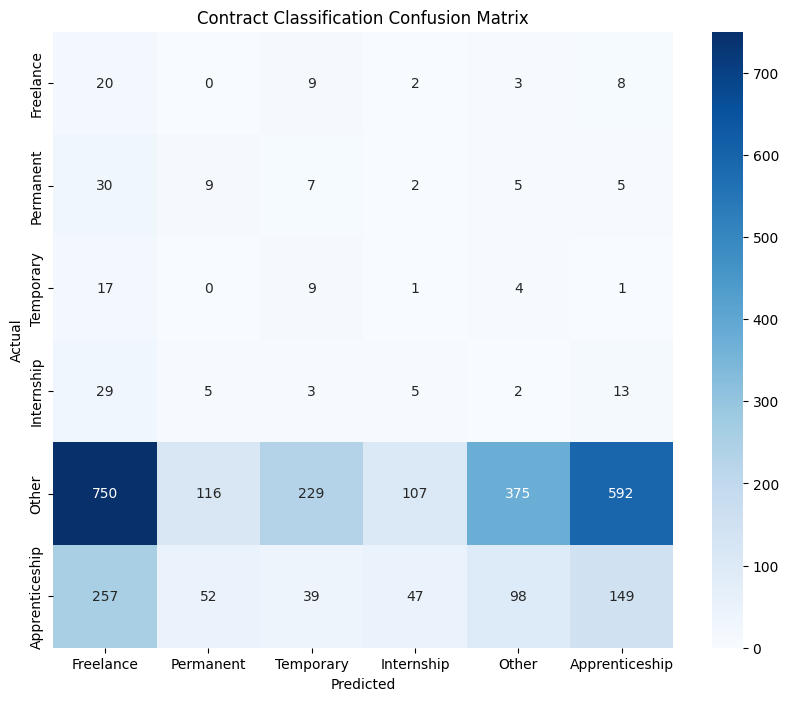

In [46]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# 3. Visualizing the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Contract Classification Confusion Matrix')
plt.show()

## Using the model for the language

In [35]:
labels_lang = list(set(Language_truth.values()))

print("Number of labels:", len(labels_lang))
print(labels_lang)

Number of labels: 5
['ar', 'pl', 'es', 'fr', 'en']


In [36]:
generator_lang_tag = outlines.Generator(model, eval('Literal'+str(labels_lang)))

In [ ]:
tags_language = {}

for job_id, job_text in tqdm(jobs.items(), desc="Tagging Language"):
    try:
        prompt = f"""Task: Identify the language for the job description below.

Job Description:
{job_text}
"""
        result = generator_lang_tag(prompt)

        tags_language[job_id] = result

    except Exception as e:
        print(f"\nError on job {job_id}: {e}")
        tags_language[job_id] = "Other" 

print(f"Finished! Tagged {len(tags_language)} jobs.")

Tagging Language: 100%|██████████| 3000/3000 [11:14<00:00,  4.45it/s]

Finished! Tagged 3000 jobs.


## Evaluation of the models

In [40]:
keys = Language_truth.keys()

y_true = [Language_truth[k] for k in keys]
y_pred = [tags_language[k] for k in keys]

cm = confusion_matrix(y_true, y_pred)

Accuracy: 0.0110
Weighted Precision: 0.9697
Weighted Recall: 0.0110
Weighted F1 Score: 0.0192

Classification Report:

              precision    recall  f1-score   support

          ar       0.00      1.00      0.00         2
          en       0.00      0.01      0.00        86
          es       0.00      0.50      0.00         2
          fr       1.00      0.01      0.02      2909
          pl       0.00      0.00      0.00         1

    accuracy                           0.01      3000
   macro avg       0.20      0.30      0.01      3000
weighted avg       0.97      0.01      0.02      3000



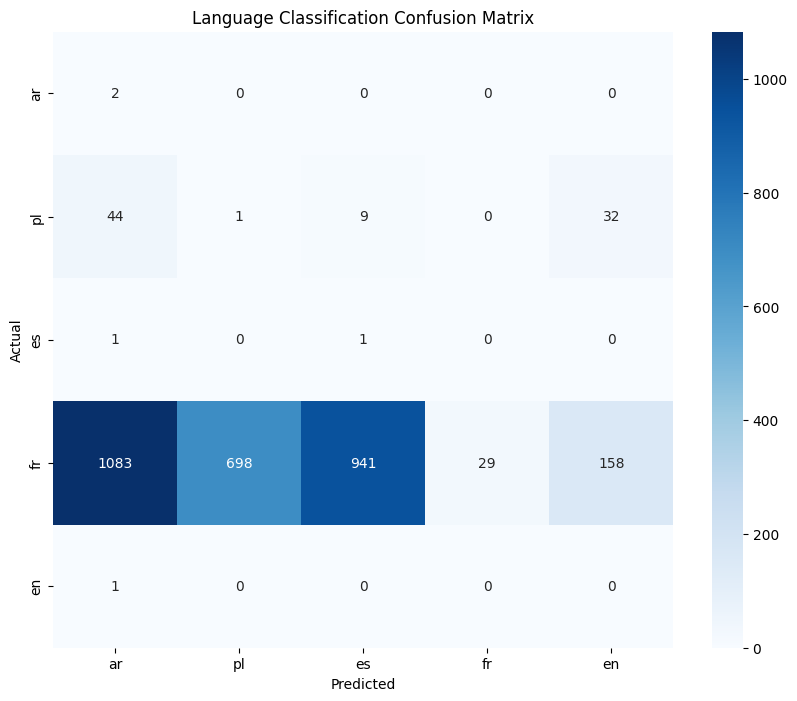

In [43]:
# 1. Basic Metrics
# For multi-class, we use 'macro' or 'weighted' averaging
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# 2. Detailed Classification Report (Best for per-language performance)
# This gives you precision, recall, and F1 for every single language
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# 3. Visualizing the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Language Classification Confusion Matrix')
plt.show()